In [21]:
import time
from src.method_selector import MlMethodSelector, ClassicMethodSelector
from src.measurement_provider import MeasurementProvider
from src.serializer import SenMLCBORSerializer, SenMLJSONSerializer
from src.signal_generator import SignalGenerator
from sys import getsizeof
from src.metric import FeatureMetricEnum, SimilarityMetricEnum
from src.data_type import Measurement
import pandas as pd
import matplotlib as plt
from src.metric import SimilarityMetricEnum
import random
plt.rcParams["figure.dpi"] = 150
pd.set_option('display.max_columns', None)

In [22]:
def compute_sizes(dataset, compressed_data, metrics):
  senML_cbor_size_original = getsizeof(SenMLCBORSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_cbor_size_compressed = getsizeof(SenMLCBORSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_cbor_size_diff = senML_cbor_size_original - senML_cbor_size_compressed
  senML_cbor_size_ratio = senML_cbor_size_diff / senML_cbor_size_original

  senML_json_size_original = getsizeof(SenMLJSONSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_json_size_compressed = getsizeof(SenMLJSONSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_json_size_diff = senML_json_size_original - senML_json_size_compressed
  senML_json_size_ratio = senML_json_size_diff / senML_json_size_original
  return {
    'senML_cbor_size_original': senML_cbor_size_original,
    'senML_cbor_size_compressed': senML_cbor_size_compressed,
    'senML_cbor_size_diff': senML_cbor_size_diff,
    'senML_cbor_size_ratio': senML_cbor_size_ratio,

    'senML_json_size_original': senML_json_size_original,
    'senML_json_size_compressed': senML_json_size_compressed,
    'senML_json_size_diff': senML_json_size_diff,
    'senML_json_size_ratio': senML_json_size_ratio,
  }

def current_milis():
  return time.time() * 1000
  
def run_measurements(dataset, get_measurements):
  constraint = {
    SimilarityMetricEnum.compression_rate: 0.5,
    SimilarityMetricEnum.sum_differences: 0.7,
    SimilarityMetricEnum.arithmetic_average: 0.5,
    SimilarityMetricEnum.standard_derivative: 0.5,
    SimilarityMetricEnum.function_field: 0.5,
    SimilarityMetricEnum.diff_of_min: 0.1,
    SimilarityMetricEnum.diff_of_max: 0.1,
    SimilarityMetricEnum.min_max_diff: 0.1,
    # SimilarityMetricEnum.value_crossing: 0.5,
    # SimilarityMetricEnum.positive_value_crossing: 0.5,
    # SimilarityMetricEnum.negative_value_crossing: 0.5,
    # SimilarityMetricEnum.peak_count: 0.5,
    # SimilarityMetricEnum.positive_peak_count: 0.5,
    # SimilarityMetricEnum.negative_peak_count: 0.5,
    SimilarityMetricEnum.median: 0.2,
    SimilarityMetricEnum.covariance: 0.1,
    SimilarityMetricEnum.corelation_pearson: 0.1,
    SimilarityMetricEnum.corelation_spearman: 0.1,
  }
  ml_method_selector = MlMethodSelector()
  ml_method_selector.use_constraint_strategy(constraint)
  ml_method_selector.set_measurements(dataset)
  score = ml_method_selector.train()
  print(score)

  naive_method_selector = ClassicMethodSelector()

  print("datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio")

  results = {
    "datasize": [],
    "ml_time": [],
    "naive_time": [],
    "ml_compressed_size": [],
    "naive_compressed_size": [],
    "ml_compression_ratio": [],
    "naive_compression_ratio": [],
    "ml_method": [],
    "naive_method": [],
    "ml_score": [],
    "naive_score": [],
    "ml_cbor_original_size": [],
    "ml_cbor_compressed_size": [],
    "ml_cbor_compressratio": [],
    "naive_cbor_original_size": [],
    "naive_cbor_compressed_size": [],
    "naive_cbor_compressratio": [],
    "ml_json_original_size": [],
    "ml_json_compressed_size": [],
    "ml_json_compressratio": [],
    "naive_json_original_size": [],
    "naive_json_compressed_size": [],
    "naive_json_compressratio": [],
  }

  for datasize in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    measurements = get_measurements(datasize)

    time_start = current_milis()
    compressed_data, stats, metrics = ml_method_selector.compress_with_best(measurements)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)
    metrics_score = ClassicMethodSelector().compute_similarity_with_constraint_strategy(measurements, compressed_data, constraint)

    ml_time = time_end - time_start
    ml_compressed_size = stats['compressed_size']
    ml_compression_ratio = stats['compression_rate'] * 100
    ml_method = stats['method_name']
    ml_score = metrics_score
    ml_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    ml_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    ml_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    ml_json_original_size = serialized_data_stats['senML_json_size_original']
    ml_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    ml_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['datasize'].append(datasize);
    results['ml_time'].append(ml_time);
    results['ml_compressed_size'].append(ml_compressed_size);
    results['ml_compression_ratio'].append(ml_compression_ratio);
    results['ml_method'].append(ml_method);
    results['ml_score'].append(ml_score);
    results['ml_cbor_original_size'].append(ml_cbor_original_size);
    results['ml_cbor_compressed_size'].append(ml_cbor_compressed_size);
    results['ml_cbor_compressratio'].append(ml_cbor_compressratio);
    results['ml_json_original_size'].append(ml_json_original_size);
    results['ml_json_compressed_size'].append(ml_json_compressed_size);
    results['ml_json_compressratio'].append(ml_json_compressratio);

    ##############################################

    time_start = current_milis()
    compressed_data, stats, metrics, metrics_score = naive_method_selector.compress_with_best_constraint_strategy(measurements, constraint)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)

    naive_time = time_end - time_start
    naive_compressed_size = stats['compressed_size']
    naive_compression_ratio = stats['compression_rate'] * 100
    naive_method = stats['method_name']
    naive_score = metrics_score
    naive_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    naive_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    naive_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    naive_json_original_size = serialized_data_stats['senML_json_size_original']
    naive_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    naive_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['naive_time'].append(naive_time);
    results['naive_compressed_size'].append(naive_compressed_size);
    results['naive_compression_ratio'].append(naive_compression_ratio);
    results['naive_method'].append(naive_method);
    results['naive_score'].append(naive_score);
    results['naive_cbor_original_size'].append(naive_cbor_original_size);
    results['naive_cbor_compressed_size'].append(naive_cbor_compressed_size);
    results['naive_cbor_compressratio'].append(naive_cbor_compressratio);
    results['naive_json_original_size'].append(naive_json_original_size);
    results['naive_json_compressed_size'].append(naive_json_compressed_size);
    results['naive_json_compressratio'].append(naive_json_compressratio);

    print(f'{datasize},{ml_time},{naive_time},{ml_compressed_size},{naive_compressed_size},{ml_compression_ratio},{naive_compression_ratio},{ml_method},{naive_method},{ml_score},{naive_score},{ml_cbor_original_size},{ml_cbor_compressed_size},{ml_cbor_compressratio},{naive_cbor_original_size},{naive_cbor_compressed_size},{naive_cbor_compressratio},{ml_json_original_size},{ml_json_compressed_size},{ml_json_compressratio},{naive_json_original_size},{naive_json_compressed_size},{naive_json_compressratio}')
  return pd.DataFrame.from_dict(results)

In [23]:
dataset = MeasurementProvider().get_random3()
# df = run_measurements(dataset, lambda datasize: MeasurementProvider().to_measurements(SignalGenerator(0, datasize).linear(2.5).sin(1, 0.2)))
df = run_measurements(dataset, lambda datasize: MeasurementProvider().to_measurements(SignalGenerator(0, datasize).with_peaks(4).with_peaks(3, direction=-1).sin(2, 0.2).linear(0.05).noise()))

(0.7333333333333333, 0.7333333333333333)
datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
100,1.5390625,96.43798828125,40,30,60.0,70.0,CompressPIP_PD_0.4,CompressPIP_ED_0.3,72.7233,87.7844,2323,1124,0.5161429186396901,2323,925,0.6018080068876452,5429,2413,0.5555350893350525,5415,1889,0.6511542012927054
200,3.042236328125,264.54296875,80,60,60.0,70.0,CompressPIP_PD_0.4,CompressPIP_ED_0.3,74.3158,87.9408,4323,1924,0.554938699976868,4323,1525,0.647235715938006,10474,4391,0.5807714340271147,10471,3380,0.6772037054722567
300,4.505126953125,477.822998046875,120,60,60.0,80.0,CompressPIP_PD_0.4,Compres

In [24]:
# df = pd.read_csv('./results3a.csv')
# df['ml_compression_ratio'] *= 100
# df['naive_compression_ratio'] *= 100

In [25]:
df1 = df
df

,datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
0,100,1.539062,96.437988,40,30,60.0,70.0,CompressPIP_PD_0.4,CompressPIP_ED_0.3,72.7233,87.7844,2323,1124,0.516143,2323,925,0.601808,5429,2413,0.555535,5415,1889,0.651154
1,200,3.042236,264.542969,80,60,60.0,70.0,CompressPIP_PD_0.4,CompressPIP_ED_0.3,74.3158,87.9408,4323,1924,0.554939,4323,1525,0.647236,10474,4391,0.580771,10471,3380,0.677204
2,300,4.505127,477.822998,120,60,60.0,80.0,CompressPIP_PD_0.4,CompressPIP_PD_0.2,74.2877,88.1856,6324,2724,0.569260,6324,1524,0.759013,15639,6453,0.587378,15666,3413,0.782140
3,400,6.954834,807.170166,160,80,60.0,80.0,CompressPIP_PD_0.4,CompressPIP_ED_0.2,70.6503,88.5740,8324,3525,0.576526,8324,1925,0.768741,20860,8559,0.589693,20831,4427,0.787480
4,500,8.961182,1127.876953,200,150,60.0,70.0,CompressPIP_PD_0.4,CompressPIP_PD_0.3,74.5776,89.2201,10324,4324,0.581170,10324,3324,0.678032,25972,10582,0.592561,25986,8033,0.690872
5,600,10.526855,1606.403076,240,180,60.0,70.0,CompressPIP_PD_0.4,CompressPIP_PD_0.3,74.1794,89.3554,12324,5126,0.584064,12324,3925,0.681516,31115,12632,0.594022,31115,9557,0.692849
6,700,14.999023,2086.860107,280,140,60.0,80.0,CompressPIP_PD_0.4,CompressPIP_PD_0.2,74.3776,88.9088,14412,5956,0.586733,14412,3141,0.782057,36320,14765,0.593475,36276,7537,0.792232
7,800,17.611816,2561.364258,320,240,60.0,70.0,CompressPIP_PD_0.4,CompressPIP_PD_0.3,73.7916,88.5477,16612,6817,0.589634,16612,5202,0.686853,41418,16794,0.594524,41419,12692,0.693571
8,900,20.023193,3259.032959,360,180,60.0,80.0,CompressPIP_PD_0.4,CompressPIP_PD_0.2,74.5451,89.0711,18812,7696,0.590899,18812,4025,0.786041,46495,18797,0.595720,46495,9560,0.794386
9,1000,19.228271,3769.057617,400,300,60.0,70.0,CompressPIP_PD_0.4,CompressPIP_PD_0.3,73.4046,88.0370,21012,8580,0.591662,21012,6536,0.688940,51654,20882,0.595733,51700,15792,0.694545


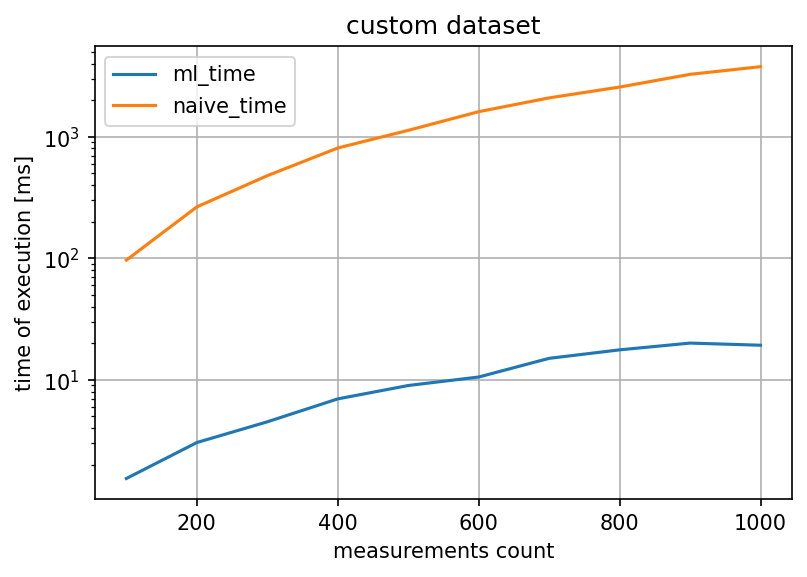

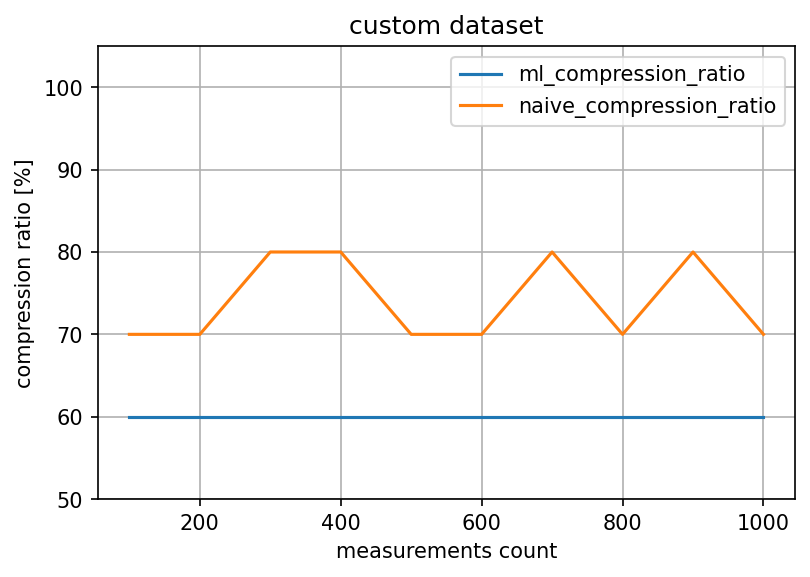

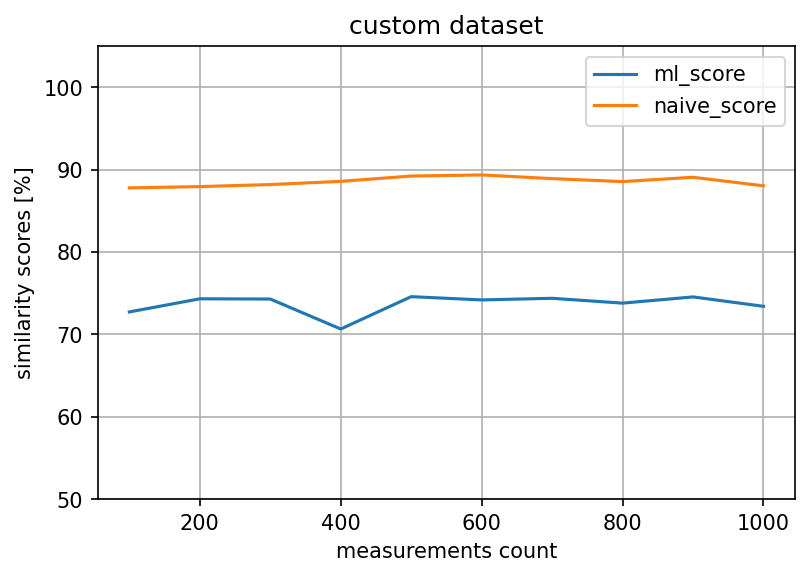

In [26]:
path = '../plot/strategy3'
ax = df.plot(x='datasize', y=['ml_time', 'naive_time'], grid=True)
ax.set_yscale("log")
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1a.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'naive_compression_ratio'], grid=True)
ax.set_ylim(50, 105)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2a.png')

# ax = df.plot(x='datasize', y=['ml_compressed_size', 'naive_compressed_size'], grid=True)
# ax.set_title("custom dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("compresed measurement set count")
# ax.figure.savefig(f'{path}/3a.png')

ax = df.plot(x='datasize', y=['ml_score', 'naive_score'], grid=True)
ax.set_ylim(50, 105)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores [%]")
ax.figure.savefig(f'{path}/4a.png')

# ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'naive_cbor_compressed_size', 'ml_json_compressed_size', 'naive_json_compressed_size'], grid=True, ylim=0)
# ax.set_title("custom dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("data size [B]")
# ax.figure.savefig(f'{path}/5a.png')


In [27]:
measurements1 = MeasurementProvider().json_to_measurements('stock1.json')
size1 = len(measurements1)
dataset = []
for i in range(10):
  start = int(random.randint(0, size1) * 0.7)
  end = random.randint(start, size1)
  dataset.append(measurements1[start:end])
df = run_measurements(dataset, lambda datasize: MeasurementProvider().json_to_measurements('stock1.json')[:datasize])

(1.0, 1.0)
datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
100,1.079833984375,100.73095703125,11,10,89.0,90.0,CompressNTHS_0.1,CompressPWP_0.1,73.0634,84.2889,2529,571,0.7742190589165678,2529,549,0.7829181494661922,5774,1002,0.8264634568756495,5775,951,0.8353246753246754
200,1.763916015625,277.578857421875,21,20,89.5,90.0,CompressNTHS_0.1,CompressPIP_PD_0.1,100,88.4188,4729,791,0.8327341932755339,4729,769,0.8373863396066822,11154,1500,0.865519096288327,11119,1405,0.8736397158017807
300,2.572998046875,504.810791015625,31,30,89.66666666666666,90.0,CompressNTHS_0.1,CompressPIP_PD_0.1,72.8333,88.2

In [28]:
# df = pd.read_csv('./results3b.csv')
# df['ml_compression_ratio'] *= 100
# df['naive_compression_ratio'] *= 100

In [29]:
df2 = df
df

,datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
0,100,1.079834,100.730957,11,10,89.000000,90.00,CompressNTHS_0.1,CompressPWP_0.1,73.0634,84.2889,2529,571,0.774219,2529,549,0.782918,5774,1002,0.826463,5775,951,0.835325
1,200,1.763916,277.578857,21,20,89.500000,90.00,CompressNTHS_0.1,CompressPIP_PD_0.1,100.0000,88.4188,4729,791,0.832734,4729,769,0.837386,11154,1500,0.865519,11119,1405,0.873640
2,300,2.572998,504.810791,31,30,89.666667,90.00,CompressNTHS_0.1,CompressPIP_PD_0.1,72.8333,88.2494,6930,1011,0.854113,6930,989,0.857287,16607,2070,0.875354,16529,1933,0.883054
3,400,5.162109,793.159912,40,41,90.000000,89.75,CompressPIP_PD_0.1,CompressMinMax_0.1,100.0000,83.9747,9130,1209,0.867579,9130,1231,0.865170,21999,2521,0.885404,22017,2607,0.881591
4,500,6.478271,1036.158691,50,49,90.000000,90.20,CompressPIP_PD_0.1,CompressPAAVI_0.1,100.0000,85.4928,11330,1429,0.873875,11330,1599,0.858870,27367,3006,0.890160,27453,3145,0.885441
5,600,8.240234,1525.274170,60,60,90.000000,90.00,CompressPIP_PD_0.1,CompressPIP_PD_0.1,75.2855,90.3426,13530,1649,0.878123,13530,1649,0.878123,32900,3615,0.890122,32900,3615,0.890122
6,700,5.422119,1826.142090,70,70,90.000000,90.00,CompressPWP_0.1,CompressPIP_PD_0.1,100.0000,90.0216,15730,1869,0.881182,15730,1869,0.881182,38371,4209,0.890308,38311,4145,0.891807
7,800,5.961914,2180.864014,90,80,88.750000,90.00,CompressPWP_0.1,CompressPIP_ED_0.1,100.0000,90.4003,17930,2309,0.871221,17930,2089,0.883491,43755,5263,0.879717,43707,4672,0.893106
8,900,6.447021,2815.560059,109,90,87.888889,90.00,CompressPWP_0.1,CompressPIP_PD_0.1,72.1020,90.6874,20130,2727,0.864531,20130,2309,0.885296,49348,6385,0.870613,49192,5186,0.894576
9,1000,7.234131,3325.466064,114,100,88.600000,90.00,CompressPWP_0.1,CompressPIP_PD_0.1,72.5591,89.8612,22330,2837,0.872951,22330,2529,0.886744,54837,6595,0.879734,54744,5745,0.895057


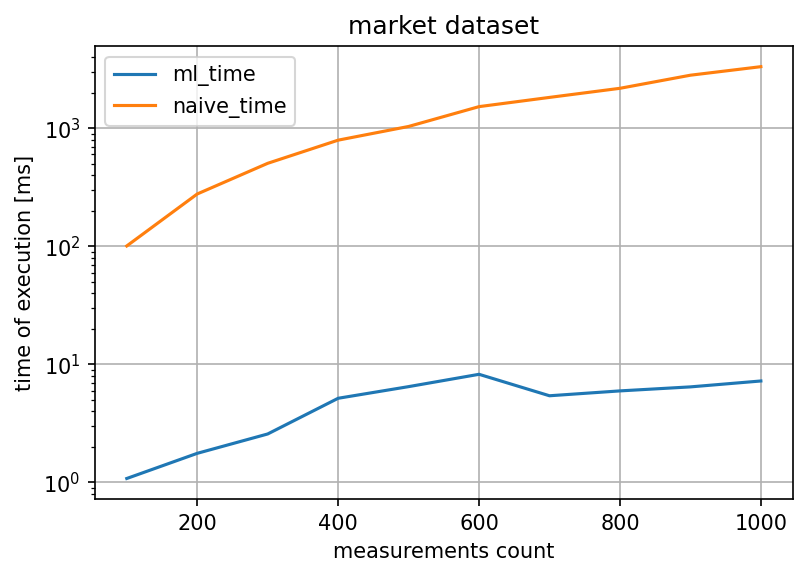

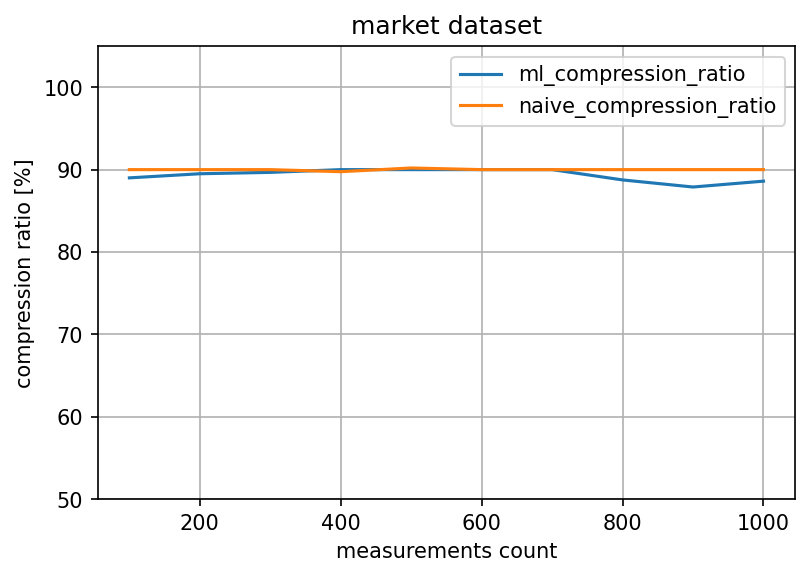

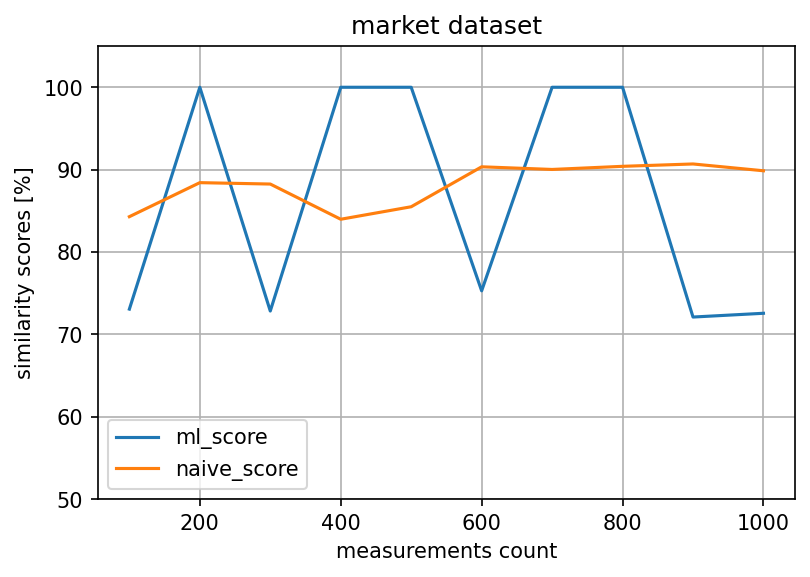

In [30]:
path = '../plot/strategy3'
ax = df.plot(x='datasize', y=['ml_time', 'naive_time'], grid=True)
ax.set_yscale("log")
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1b.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'naive_compression_ratio'], grid=True)
ax.set_ylim(50, 105)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2b.png')

# ax = df.plot(x='datasize', y=['ml_compressed_size', 'naive_compressed_size'], grid=True)
# ax.set_title("market dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("compresed measurement set count")
# ax.figure.savefig(f'{path}/3b.png')

ax = df.plot(x='datasize', y=['ml_score', 'naive_score'], grid=True)
ax.set_ylim(50, 105)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores [%]")
ax.figure.savefig(f'{path}/4b.png')

# ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'naive_cbor_compressed_size', 'ml_json_compressed_size', 'naive_json_compressed_size'], grid=True, ylim=0)
# ax.set_title("market dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("data size [B]")
# ax.figure.savefig(f'{path}/5b.png')

